### 第1章 QuantLib入門とTiborレートの実装

In [ ]:
#!pip install QuantLib

In [1]:
import datetime
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt

import QuantLib as ql

# QuantLib カレンダー 日付の設定
calJP = ql.Japan()   #ql.NullCalendar()

# matplotlibグラフの表示設定(日本語フォントとサイズ、グラフサイズ)
plt.rcParams.update({"font.family":"MS Gothic","font.size":12,
                     "figure.figsize":[6,4]})

#### 1.1 Python と QunatLib の date クラスのキャスト (型変換)

(参照)[Converting pandas datetime to QuantLib dates](https://quant.stackexchange.com/questions/60991/converting-pandas-datetime-to-quantlib-dates-why-do-the-inputs-need-to-be-conve) in StackExchange

In [2]:
help(calJP)

Help on Japan in module QuantLib.QuantLib object:

class Japan(Calendar)
 |  Proxy of C++ QuantLib::Japan class.
 |  
 |  Method resolution order:
 |      Japan
 |      Calendar
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      __init__(Japan self) -> Japan
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __swig_destroy__ = delete_Japan(...)
 |      delete_Japan(Japan self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  thisown
 |      The membership flag
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Calendar:
 |  
 |  __eq__(self, other)
 |      __eq__(Calendar self, Calendar other) -> bool
 |  
 |  __hash__(self)
 |      Return hash(self).
 |  
 |  __ne__(self, other)
 |      __ne__(Calendar self, Calend

In [3]:
calJP.isHoliday(ql.Date('2022-08-11', '%Y-%m-%d'))

True

In [4]:
calJP.advance(ql.Date('2022-08-10', '%Y-%m-%d'), ql.Period('2d'))

Date(15,8,2022)

In [5]:
calJP.advance(ql.Date('2022-08-10', '%Y-%m-%d'), 2, ql.Days)

Date(15,8,2022)

In [6]:
(calJP.advance(ql.Date('2022-08-10', '%Y-%m-%d'), 2, ql.Days)).ISO()

'2022-08-15'

- JointCalendar

In [7]:
calJpUs = ql.JointCalendar(calJP, ql.UnitedStates(ql.UnitedStates.FederalReserve))  #, ql.JoinHolidays)
calJpUs.advance(ql.Date('2022-07-01', '%Y-%m-%d'), ql.Period('1d'))

Date(5,7,2022)

In [8]:
dt1 = datetime.date.fromisoformat('2022-08-11')
ql.Date().from_date(dt1)

Date(11,8,2022)

In [9]:
dt2 = ql.Date('2022-08-11', '%Y-%m-%d')
dt2.to_date()

datetime.date(2022, 8, 11)

In [10]:
help(ql.Date())

Help on Date in module QuantLib.QuantLib object:

class Date(builtins.object)
 |  Date(*args)
 |  
 |  Proxy of C++ Date class.
 |  
 |  Methods defined here:
 |  
 |  ISO(self)
 |      ISO(Date self) -> std::string
 |  
 |  __add__ = Date_new___add__(self, x)
 |  
 |  __bool__(self)
 |      __bool__(Date self) -> bool
 |  
 |  __cmp__(self, other)
 |      __cmp__(Date self, Date other) -> int
 |  
 |  __eq__(self, other)
 |      __eq__(Date self, Date other) -> bool
 |  
 |  __ge__(self, other)
 |      __ge__(Date self, Date other) -> bool
 |  
 |  __gt__(self, other)
 |      __gt__(Date self, Date other) -> bool
 |  
 |  __hash__(self)
 |      __hash__(Date self) -> int
 |  
 |  __init__(self, *args)
 |      __init__(Date self) -> Date
 |      __init__(Date self, Day d, Month m, Year y) -> Date
 |      __init__(Date self, Day d, Month m, Year y, Hour hours, Minute minutes, Second seconds, Millisecond millisec=0, Microsecond microsec=0) -> Date
 |      __init__(Date self, BigInteger s

In [11]:
ql.Date().todaysDate()

Date(29,11,2023)

#### 1.2 ゼロカーブ オブジェクトとディスカウントファクター

In [12]:
dates = [ql.Date('2022-08-03', '%Y-%m-%d'),ql.Date('2022-11-04', '%Y-%m-%d'), 
         ql.Date('2023-02-03', '%Y-%m-%d'),ql.Date('2023-08-03', '%Y-%m-%d')]
zeros = [0.0, 0.01, 0.02, 0.03]
curveOBJ = ql.ZeroCurve(dates, zeros, ql.Actual365Fixed(), calJP)
           # 残り3つの引数の初期値は ql.Linear(), ql.Continuous, ql.Annual
curveOBJ.nodes()

((Date(3,8,2022), 0.0),
 (Date(4,11,2022), 0.01),
 (Date(3,2,2023), 0.02),
 (Date(3,8,2023), 0.03))

In [13]:
curveOBJ.zeroRates()

(0.0, 0.01, 0.02, 0.03)

In [14]:
#help(curveOBJ)
curveOBJ.discount(ql.Date('2023-03-01', '%Y-%m-%d')) 

0.9877424354295338

- Discount Factorの再計算

In [15]:
print('dayCounter   ', curveOBJ.dayCounter())
print('referenceDate', curveOBJ.referenceDate())
print('times    {:.6f}, {:.6f}, {:.6f}, {:.6f}'.format(*curveOBJ.times()) )
print('discount {:.6f}, {:.6f}, {:.6f}, {:.6f}'
                         .format(*[curveOBJ.discount(dt) for dt in dates]))

dayCounter    Actual/365 (Fixed) day counter
referenceDate August 3rd, 2022
times    0.000000, 0.254795, 0.504110, 1.000000
discount 1.000000, 0.997455, 0.989968, 0.970446


In [16]:
tau = (ql.Date('2022-11-04', '%Y-%m-%d') - ql.Date('2022-08-03', '%Y-%m-%d'))/365
print('tau     : {:.6f}'.format(tau) )
print('discount: {:.6f}'.format(np.exp(-0.01*tau)) )

tau     : 0.254795
discount: 0.997455


補間レート
- 2023-08-03 - 2023-02-03 = 181日、2023-05-03 - 2023-02-03 =  89日
- 補間レート = 89日*0.01 / 181日 + 0.02 

In [17]:
rate0503 = curveOBJ.zeroRate(ql.Date('2023-05-03', '%Y-%m-%d'),
                        ql.Actual365Fixed(),ql.Continuous)
print(rate0503)     #print(rate0503.rate())

2.491713 % Actual/365 (Fixed) continuous compounding


In [18]:
d089 = ql.Date('2023-05-03','%Y-%m-%d')-ql.Date('2023-02-03','%Y-%m-%d') #89
d181 = ql.Date('2023-08-03','%Y-%m-%d')-ql.Date('2023-02-03','%Y-%m-%d') #181
handCalc = (0.03 - 0.02) * d089/d181 + 0.02
print('handCalc   : {:.6f}'.format(handCalc))

handCalc   : 0.024917


- [LinearInterpolationオブジェクト](https://quantlib-python-docs.readthedocs.io/en/latest/mathTools.html#d-interpolation-method)

In [19]:
dayS = [0, d181]
zeroRates = [0.02, 0.03]
interPO = ql.LinearInterpolation(dayS, zeroRates)
print('interPO Obj: {:.6%}'.format(interPO(d089)) )

interPO Obj: 2.491713%


In [20]:
cDateSN, cRateSN = list(zip(*[(dt.serialNumber(), rate) for dt,rate in curveOBJ.nodes()]))
# Making interploation instance then calculate
linearIP = ql.LinearInterpolation(cDateSN, cRateSN)
rateMay03 = linearIP(ql.Date('2023-05-03', '%Y-%m-%d').serialNumber(), allowExtrapolation=True)
print('2023-05-03: {:.6f}'.format(rateMay03))

2023-05-03: 0.024917


In [21]:
rate0503OBJ = curveOBJ.zeroRate(ql.Date('2023-05-03', '%Y-%m-%d'),
                        ql.Actual365Fixed(),ql.Continuous)
help(rate0503OBJ)

Help on InterestRate in module QuantLib.QuantLib object:

class InterestRate(builtins.object)
 |  InterestRate(*args)
 |  
 |  Proxy of C++ InterestRate class.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args)
 |      __init__(InterestRate self) -> InterestRate
 |      __init__(InterestRate self, Rate r, DayCounter dc, Compounding comp, Frequency freq) -> InterestRate
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __str__(self)
 |      __str__(InterestRate self) -> std::string
 |  
 |  compoundFactor(self, *args)
 |      compoundFactor(InterestRate self, Time t) -> Real
 |      compoundFactor(InterestRate self, Date d1, Date d2, Date refStart=Date(), Date refEnd=Date()) -> Real
 |  
 |  compounding(self)
 |      compounding(InterestRate self) -> Compounding
 |  
 |  dayCounter(self)
 |      dayCounter(InterestRate self) -> DayCounter
 |  
 |  discountFactor(self, *args)
 |      discountFactor(InterestRate self, Time t) -> DiscountFactor
 |      discountFactor(InterestRate se

In [22]:
[np.exp(-r*t) for t, r in zip(curveOBJ.times(), zeros)]

[1.0, 0.9974552980517736, 0.9899684631342734, 0.9704455335485082]

In [23]:
list(zip(*[(dt.to_date(), rate) for dt,rate in curveOBJ.nodes()]))

[(datetime.date(2022, 8, 3),
  datetime.date(2022, 11, 4),
  datetime.date(2023, 2, 3),
  datetime.date(2023, 8, 3)),
 (0.0, 0.01, 0.02, 0.03)]

- zip(* )によって リストを転置  
(参照) [Matplotlib 軸周り完璧マスターガイド](https://www.yutaka-note.com/entry/matplotlib_axis#%E8%BB%B8%E5%91%A8%E3%82%8A%E3%81%AE%E8%A8%AD%E5%AE%9A%E7%B7%8F%E3%81%BE%E3%81%A8%E3%82%81)

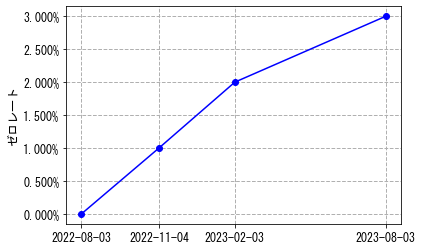

In [24]:
cDates, cRates = list(zip(*[(dt.to_date(), rt) for dt,rt in curveOBJ.nodes()]))
plt.plot(cDates, cRates, color="b", marker='o')
plt.xticks(cDates); plt.ylabel('ゼロレート')
plt.grid(linestyle='--',linewidth=1)                            # グリッド表示
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1,3))

(補足)
- 次のグラフは各軸の表示法を修正した例でDateFormatter, FuncFormatterを使用したサンプルである。DateFormatterの記入は説明を省略するが、lambda関数を使ったFuncFormatterの記入法の説明は「補足」を参照しよう。
- 分割部分をアンパックで記し, matplotlibのDateFormatterでx軸表示を変更し
- y軸はFuncFormatterによって、%表示へ(%表示の簡便なやり方が不明なので、FuncFormatterを使用)

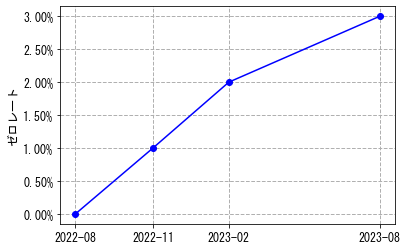

In [25]:
from matplotlib import dates as mdt
from matplotlib.ticker import FuncFormatter

cDates, cRates = list(zip(*[(dt.to_date(), rt) for dt,rt in curveOBJ.nodes()]))
plt.plot(cDates, cRates, color="b", marker='o')
plt.xticks(cDates); plt.ylabel('ゼロレート')
plt.grid(linestyle='--',linewidth=1)                            # グリッド表示
plt.gca().xaxis.set_major_formatter(mdt.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda r,pos: "{:.2%}".format(r)))

- 次のコードはカーブオブジェクトのenableExtrapolationメソッドで補外できるようにし、30年までのディスカウントカーブを描写した例である。

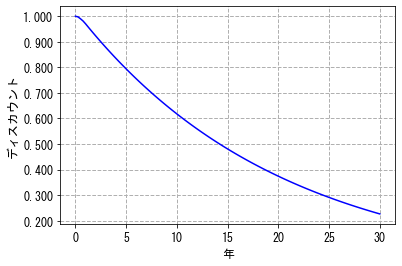

In [26]:
curveOBJ.enableExtrapolation()
timeTICK = np.linspace(0.0, 30.0, 121)
discFCTR = [curveOBJ.discount(t) for t in timeTICK]
plt.plot(timeTICK, discFCTR, color="b");plt.ylabel('ディスカウント');plt.xlabel('年')
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))  # y軸の桁数
plt.grid(linestyle='--',linewidth=1)                                 # グリッド表示

#### 1.3 Tiborレートのディスカウントファクターとクォート(建値)

In [27]:
tau = (ql.Date('2022-11-04', '%Y-%m-%d') - ql.Date('2022-08-03', '%Y-%m-%d'))/365
print('tau     : {:.6f}'.format(tau) )
print('discount: {:.6f}'.format(1/(1+0.01*tau)) )

tau     : 0.254795
discount: 0.997459


In [28]:
curveOBJ = ql.ZeroCurve(dates, zeros, ql.Actual365Fixed(), calJP, 
                         ql.Linear(), ql.Simple, ql.Annual)
curveOBJ.discount(ql.Date('2022-11-04', '%Y-%m-%d')) 

0.9974585303200065

In [29]:
print('todayDate:      ', ql.Date().todaysDate())
print('evaluationDate: ', ql.Settings.instance().evaluationDate)

todayDate:       November 29th, 2023
evaluationDate:  November 29th, 2023


In [30]:
tradeDT = ql.Date('2022-08-01','%Y-%m-%d')
ql.Settings.instance().evaluationDate = tradeDT
calJP, Tp2 = ql.Japan(), 2                         # Tp2 := T+2
settleDT = calJP.advance(tradeDT, Tp2, ql.Days)

rate3m = ql.SimpleQuote(0.01)
rate6m = ql.SimpleQuote(0.02)
rate12m = ql.SimpleQuote(0.03)

tbr3m = ql.Tibor(ql.Period('3M'))
tbr6m = ql.Tibor(ql.Period('6M'))
tbr12m = ql.Tibor(ql.Period('12M'))

helper3M = ql.DepositRateHelper(ql.QuoteHandle(rate3m), tbr3m)
helper6M = ql.DepositRateHelper(ql.QuoteHandle(rate6m), tbr6m) 
helper12M = ql.DepositRateHelper(ql.QuoteHandle(rate12m),  tbr12m)
helpers = [helper3M, helper6M, helper12M ]

curveOBJ = ql.PiecewiseLogLinearDiscount(
                        settleDT, helpers, ql.Actual365Fixed())
curveOBJ.nodes()

((Date(3,8,2022), 1.0),
 (Date(4,11,2022), 0.9974585303200327),
 (Date(3,2,2023), 0.9900184441792355),
 (Date(3,8,2023), 0.9708737864077671))

In [31]:
rate3m.setValue(0.02)
curveOBJ.nodes()

((Date(3,8,2022), 1.0),
 (Date(4,11,2022), 0.9949299460284549),
 (Date(3,2,2023), 0.9900184441792355),
 (Date(3,8,2023), 0.9708737864077671))

In [32]:
tradeDT = ql.Date('2022-08-01', '%Y-%m-%d')
settleDT = tbr3m.valueDate(tradeDT)         #2022-08-03
print('trade          : ', tradeDT)
print('settle         : ', settleDT)
print('--------------- ---------------------')
print('fixingDays     : ', tbr3m.fixingDays())
print('fixingDate     : ', tbr3m.fixingDate(settleDT), '\n')

print('tenor          : ', tbr3m.tenor())
print('dayCounter     : ', tbr3m.dayCounter())
print('fixingCalendar : ', tbr3m.fixingCalendar())
print('maturityDate   : ', tbr3m.maturityDate(settleDT))

trade          :  August 1st, 2022
settle         :  August 3rd, 2022
--------------- ---------------------
fixingDays     :  2
fixingDate     :  August 1st, 2022 

tenor          :  3M
dayCounter     :  Actual/365 (Fixed) day counter
fixingCalendar :  Japan calendar
maturityDate   :  November 4th, 2022


In [33]:
rate3m.setValue(0.01)
curveOBJ.discount(ql.Date('2023-03-01', '%Y-%m-%d')) 

0.98724533619916

#### 1.4 xlwings入門(1) : Python関数をExcelユーザー定義関数へ

In [34]:
#!pip show xlwings
#!pip install xlwings

Name: xlwings
Version: 0.24.9
Summary: Make Excel fly: Interact with Excel from Python and vice versa.
Home-page: https://www.xlwings.org
Author: Zoomer Analytics LLC
Author-email: felix.zumstein@zoomeranalytics.com
License: BSD 3-clause
Location: c:\users\user\anaconda3\lib\site-packages
Requires: pywin32
Required-by: 


In [1]:
import xlwings as xw
@xw.func

def tiborDF(r3m, r6m, r12m, tgtDT):
    
    import QuantLib as ql
    calJP = ql.Japan()
    ql.Settings.instance().evaluationDate = ql.Date('2022-08-01', '%Y-%m-%d')
    Tp2 = 2

    rate3m = ql.SimpleQuote(r3m)
    rate6m = ql.SimpleQuote(r6m)
    rate12m = ql.SimpleQuote(r12m)

    tbr3m = ql.Tibor(ql.Period('3M'))
    tbr6m = ql.Tibor(ql.Period('6M'))
    tbr12m = ql.Tibor(ql.Period('12M'))

    helper3M = ql.DepositRateHelper(ql.QuoteHandle(rate3m), tbr3m)
    helper6M = ql.DepositRateHelper(ql.QuoteHandle(rate6m), tbr6m) 
    helper12M = ql.DepositRateHelper(ql.QuoteHandle(rate12m),  tbr12m)
    helpers = [helper3M, helper6M, helper12M ]

    curveOBJ = ql.PiecewiseLogLinearDiscount(
                    Tp2, calJP, helpers, ql.Actual365Fixed())
    curveOBJ.enableExtrapolation()
    return curveOBJ.discount(ql.Date(tgtDT, '%Y-%m-%d')) 

In [2]:
tiborDF(0.01, 0.02, 0.03, '2022-11-04')

0.9974585303200327

In [37]:
import xlwings as xw
@xw.func
@xw.arg('data', ndim=1)
def tiborDF2(data):
    r3m, r6m, r12m, tgtDT = data
    import QuantLib as ql
    calJP = ql.Japan()

    rate3m = ql.SimpleQuote(r3m)
    rate6m = ql.SimpleQuote(r6m)
    rate12m = ql.SimpleQuote(r12m)

    tbr3m = ql.Tibor(ql.Period('3M'))
    tbr6m = ql.Tibor(ql.Period('6M'))
    tbr12m = ql.Tibor(ql.Period('12M'))

    helper3M = ql.DepositRateHelper(ql.QuoteHandle(rate3m), tbr3m)
    helper6M = ql.DepositRateHelper(ql.QuoteHandle(rate6m), tbr6m) 
    helper12M = ql.DepositRateHelper(ql.QuoteHandle(rate12m),  tbr12m)
    helpers = [helper3M, helper6M, helper12M ]

    ql.Settings.instance().evaluationDate = ql.Date('2022-08-01', '%Y-%m-%d')
    Tp2 = 2
    curveOBJ = ql.PiecewiseLogLinearDiscount(
                    Tp2, calJP, helpers, ql.Actual365Fixed())
    curveOBJ.enableExtrapolation()
    return curveOBJ.discount(ql.Date(tgtDT, '%Y-%m-%d')) 

In [38]:
x = [0.01, 0.02, 0.03, '2022-11-04']
tiborDF2(x)

0.9974585303200327